# Ciência de Dados - Trabalho final

## Objetivo:

- Criação de um modelo de classificação para identificicação de malwares das categorias *Adware*, *Ransomware*, *Scareware* e *SMS Malware* em aplicações Android.

## *Dataset* utilizado:

- *Dataset* obtido da [UNB (*University of New Brunswick*)](https://www.unb.ca/cic/datasets/andmal2017.html) chamado CIC-AndMal2017, contendo dados de fluxo de tráfego rede de 10.854 aplicações Android sendo 4.354 malware e 6.500 de aplicações benignas.
- Nos arquivos relacioanados ao *dataset* há além dos CSVs com dados de fluxo de tráfego as APKs das aplicações.
- Mais detalhes sobre o *dataset* pode ser visto na seção ["Exploração de dados"](https://github.com/efbaro/CDadosSeg/blob/main/README.md) do projeto no github.


## Bibliotecas implementadas

- Alguns códigos foram implementados para auxiliar o processamento dos dados e experimentos e são listados a seguir com seus respectivos links.
    + [manifest_script.py](https://github.com/efbaro/CDadosSeg/blob/main/README.md)
    + [funcoes_uteis.py](https://github.com/efbaro/CDadosSeg/blob/main/README.md)

# Pré-processamento dos dados

- Os dados de fluxo de tráfego estão armazenados em arquivos CSVs separados em pastas por categoria e família.
- Todos os arquivos possuem a mesma estrutura com 87 colunas. 
- Para fazer o treinamento dos modelos considerando o objetivo deste trabalho, faz-se necessário a junção desses arquivos em apenas um. Este processo é apresentado na sequência desse *notebook*.

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Códigos implementados pelo autor
from lib import funcoes_uteis

In [4]:
path = '/home/efbaro/Documentos/dados/CSVs/'
# Obtém recursivamente o caminho para todos os arquivos CSVs
# a partir do ponto inicial passado como parâmetro
files = funcoes_uteis.get_csv_files(path)

df = None

for file in files:
    # Separa o nome da aplicação que está presente
    # no nome dos arquivos.
    tokens = file.split('-')
    tokens = tokens[-1].split('.pcap')
    if isinstance(df, pd.core.frame.DataFrame):
        # Lê o arquivo csv e armazena em um DataFrame
        new_df = pd.read_csv(file, delimiter=',')
        # Inclui o nome da aplicação na coluna NOME_APP
        new_df['NOME_APP'] = tokens[0]
        df = pd.concat([df, new_df])
    else:
        df = pd.read_csv(file, delimiter=',')
        df['NOME_APP'] = tokens[0]

df

In [5]:
print('Número de exemplos:', len(df))
print('Número de colunas:',len(df.columns))
print('Nomes das colunas:', [coluna for coluna in df.columns])

Número de exemplos: 2616579
Número de colunas: 86
Nomes das colunas: ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean'

## Amostragem dos dados

- Devido a grande quantidade de exemplos, mais de 2,5 milhões, a velocidade dos treinamentos pode ser damasiadamente lenta, portanto, neste trabalho será utilizado 3\% do total de exemplos, resultando em um pouco mais de 78 mil exemplos.

In [6]:
# Descomentar
df = df.sample(frac=0.03, random_state=0)
print('Número de exemplos:', len(df))

Número de exemplos: 78497


In [7]:
# Distribuição das classes
df.groupby([' Label']).size()

 Label
ADWARE_DOWGIN                 1152
ADWARE_EWIND                  1315
ADWARE_FEIWO                  1623
ADWARE_GOOLIGAN               2865
ADWARE_KEMOGE                 1182
ADWARE_KOODOUS                 959
ADWARE_MOBIDASH                951
ADWARE_SELFMITE                418
ADWARE_SHUANET                1221
ADWARE_YOUMI                  1028
BENIGN                       36344
MALWARE                         84
RANSOMWARE_CHARGER            1206
RANSOMWARE_JISUT               789
RANSOMWARE_KOLER              1284
RANSOMWARE_LOCKERPIN           755
RANSOMWARE_PLETOR              132
RANSOMWARE_PORNDROID          1354
RANSOMWARE_RANSOMBO           1164
RANSOMWARE_SIMPLOCKER         1035
RANSOMWARE_SVPENG             1661
RANSOMWARE_WANNALOCKER        1023
SCAREWARE                      229
SCAREWARE_ANDROIDDEFENDER     1700
SCAREWARE_ANDROIDSPY           768
SCAREWARE_AVFORANDROID        1219
SCAREWARE_AVPASS              1207
SCAREWARE_FAKEAPP             1036
SCAREWARE_FAK

## Ajuste na coluna *Label*

- Como o objetivo é prever *Malwares* para as categorias *Adware*, *Ransomware*, *Scareware* e *SMS Malware*, as famílias serão retiradas da coluna *Label*, mantendo apenas as categorias.

In [8]:
# Divide Label em Label e Family
df[['Label', 'Family']] = df[' Label'].str.split('_', 1, expand=True)
# Remove a antiga coluna ' Label'
df = df.drop(columns=[' Label'])

## Remoção de colunas

- Serão removidas as colunas:
    + *Timestamp* - representa apenas a data e a hora em que os dados foram coletados, não tendo relavânciaa para o objetivo estabelecido.
    + *Flow ID* - representa apenas um identificador do exemplo, não representado dado relevante para o treinamento.
    + *Family* - Como o objetivo é apenas prever as categorias dos *Malwares* a Família será descartatda.
    + *Source IP* e *Destination IP* - Como os dados são de fluxo de tráfego rede, e a captura se dá pelas duas vias, o IP do aparelho se repete muitas vezes em uma das duas colunas em todos os exemplos, e é provável que exemplos novos não possuam o mesmo IP do aparelho utilizado na captura, por este motivo essas duas colunas serão removidas.

- A coluna NOME_APP será mantida pois será utilizada mais para frente.

In [9]:
# Remove colunas desnecessárias
columns = list(df.columns)
columns.remove('Flow ID')
columns.remove(' Source IP')
columns.remove(' Destination IP')
columns.remove('Family')
columns.remove(' Timestamp')
df = df[columns]
print('Número de colunas:',len(df.columns))

Número de colunas: 82


## Remoção de exemplos

- Existe um subconjunto de exemplos rotulados apenas como *Malware*, como eles não possuem uma categoria serão eliminados.
- Também serão eliminados os registros que possuem exemplos nulos.

In [10]:
print('Número de exemplos:', len(df))

Número de exemplos: 78497


In [11]:
# Remove exemplos que têm o rótulo somente MALWARE
df = df[df['Label'] != 'MALWARE']
# Remove exemplos com valores nulos.
df = df.dropna(how='any', axis=0)

In [12]:
print('Número de exemplos:', len(df))

Número de exemplos: 78411


In [13]:
# Exibe DataFrame resultante
df

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,NOME_APP,Label
311999,49738.0,443.0,6.0,314154.0,15.0,18.0,1637.0,19098.0,737.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,2c7b372254730bfa366e4759db34812c,RANSOMWARE
2315643,33281.0,443.0,6.0,183700.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,com.asdhillon.admin.gymapplication,BENIGN
1348860,54449.0,5222.0,6.0,119979513.0,49.0,43.0,1111.0,1397.0,273.0,0.0,...,1.985529e+06,2.351435e+06,6009953.0,194744.0,1.513963e+07,3.611158e+06,20168014.0,10341591.0,68c9b7be13a2baef87370d291a5190ac,ADWARE
289365,55276.0,80.0,6.0,9791581.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,244c982e91b55edd55fab1c96c392211,RANSOMWARE
2106238,33483.0,443.0,6.0,117446695.0,23.0,16.0,4910.0,9771.0,541.0,0.0,...,2.683545e+06,3.619360e+06,5242819.0,124271.0,5.602101e+07,6.875939e+07,104641248.0,7400781.0,13bca905ccc119771040fd5fd30afff1,SCAREWARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644643,45990.0,80.0,6.0,31756458.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,zok.android.numbers,BENIGN
1265866,58928.0,80.0,6.0,115910.0,66.0,65.0,372.0,89571.0,372.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,b3a694ab3b58de4a944a3d4a03f67c6d,ADWARE
2370110,39152.0,53.0,17.0,1414090.0,1.0,1.0,32.0,207.0,32.0,32.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,com.bf.app7418de,BENIGN
955043,37919.0,80.0,6.0,10552731.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,com.jetappfactory.jetaudio,BENIGN


## Distribuição das amostras por classe

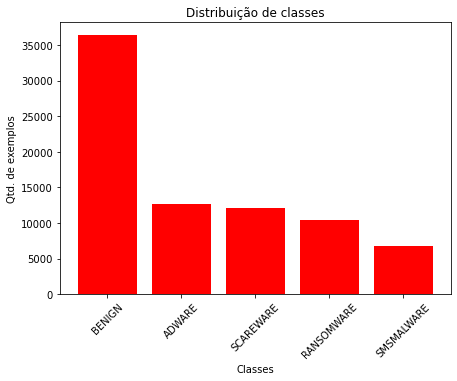

In [14]:
# Distribuição das classes
funcoes_uteis.plot_distribuicao_classes(df, 'Label')

## Salvar *dataset* preparado

- Salvar dados preparados para uso futuro.

In [15]:
# Salva DataFrame em arquivo CSV
df.to_csv(path + 'dados_fluxo_trafego.csv', index=False)
# Reseta os índices
df.reset_index(drop=True, inplace=True)

In [16]:
# Abre arquivo
#path = '/home/efbaro/Documentos/dados/CSVs/'
#df = pd.read_csv(path + 'dados_fluxo_trafego.csv', delimiter=',')

## Lendo e tranformandos dados de permissões dos Android_manifests

- Para enriquecer o *dataset* foi extraído das APKs relacionados aos dados os arquivos AndroidManifests e deles extraiu-se as permissões das aplicações, que foram tranformadas em arquivos CSVs. Essa extração foi realizada com a ajuda do script [manifest_script.py](https://github.com/efbaro/CDadosSeg/blob/main/README.md). Os arquivos CSVs foram organizados em pastas da mesma forma que os CSVs dos dados de tráfego de rede.
- Esses dados foram concatenados aos dados de trafego por meio do nome da aplicação.

In [127]:
# Lê as permissões em todos os arquvios e os coloca em um único dataset
path = '/home/efbaro/Documentos/dados/CSVs_permissions/'
files = funcoes_uteis.get_csv_files(path)

df_permissions = None

for i in range(len(files)):
    
    # Obtém rótulo a partir do diretório da aplicação
    label = files[i].replace(path, '')
    label = label.split('/')
    label = label[0].split('_')
    label = label[0]
    label
    
    if i == 0:
        df_permissions = pd.read_csv(files[i], delimiter=',')
        df_permissions['Label'] = label
    else:
        new_df =  pd.read_csv(files[i], delimiter=',')
        new_df['Label'] = label
        df_permissions = pd.concat([df_permissions, new_df])
        
df_permissions

,NOME_APP,PERMISSOES,Label
0,0639a74f508591f99a7d2309f5825fea,ACCESS_NETWORK_STATE|ACCESS_WIFI_STATE|CHANGE_...,Ransomware
1,0bccdcc7d63f0754e9e66c806e8e9203,ACCESS_NETWORK_STATE|ACCESS_WIFI_STATE|CHANGE_...,Ransomware
2,0df8e91d4ee84180099a26d97cf5baf4,ACCESS_NETWORK_STATE|ACCESS_WIFI_STATE|CHANGE_...,Ransomware
3,00357b0e208c20df3182d54cb2ba15bf,ACCESS_NETWORK_STATE|ACCESS_WIFI_STATE|CHANGE_...,Ransomware
4,02548535ff1cc285fddf699f2d77bcba,ACCESS_NETWORK_STATE|ACCESS_WIFI_STATE|CALL_PH...,Ransomware
...,...,...,...
4,c57194d05a30d53c764983c70e471791,ACCESS_NETWORK_STATE|INTERNET|READ_PHONE_STATE...,Scareware
5,8be7ac1e01b3a5db14103187232d4f75,ACCESS_COARSE_LOCATION|ACCESS_FINE_LOCATION|AC...,Scareware
6,eda9098498a6201383e311f9b3757b4f,GET_TASKS|RECEIVE_BOOT_COMPLETED|RECEIVE_SMS|R...,Scareware
7,5d7af62c7f33522a8fe50085204d90c8,ACCESS_NETWORK_STATE|ACCESS_WIFI_STATE|BROADCA...,Scareware


In [128]:
# Remove exemplos que não tem permissoes
df_permissions = df_permissions[~df_permissions['PERMISSOES'].isnull()]

### Conversão da colula de permissões em várias colunas com as respectivas permissões 

In [129]:
# Cria uma lista com as permissões
permlist = df_permissions.values.tolist()

big_list = []
for l in permlist:
    big_list += [[l[0]] + l[1].split('|') + [l[2]]]
len(big_list)

2067

In [130]:
# Obtenção do espaço amostral das permissões únicas
uniqueperms = {x for l in big_list for x in l[1:-1]}
print(len(uniqueperms))

469


In [131]:
# Definindo o novo cabeçalho
df_header = ['NOME_APP'] + list(uniqueperms) + ['Label']
len(df_header)

471

In [132]:
# Preenchimento do dataframe de treino
df_train_content = []
nperm = len(df_header)
for sample in big_list:
    has_permission = [0] * nperm 
    has_permission[0] = sample[0]
    has_permission[-1] = sample[-1]
    for perm in sample[1:-1]:
        has_permission[df_header.index(perm)] = 1
    df_train_content.append(has_permission)
df_permissoes_train = pd.DataFrame(df_train_content, columns=df_header)
pd.set_option('display.max_rows', 150)
df_permissoes_train

,NOME_APP,SENSOR_ENABLE,GALLERY_PROVIDER,CEMOJI,WRITE_HISTORY_BOOKMARKS,lh2,NFC_SE,AUTHENTICATE_ACCOUNTS,DELETE_CACHE_FILES,MDM_CONTENT_PROVIDER,...,DISABLE_KEYGUARD,wise,RECORD_VIDEO,MODIFY_PHONE_STATE,ACTION_BOOT_COMPLETED,AVIATE_INTER_APP,jotspot,SMARTCARD,sierraqa,Label
0,0639a74f508591f99a7d2309f5825fea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ransomware
1,0bccdcc7d63f0754e9e66c806e8e9203,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ransomware
2,0df8e91d4ee84180099a26d97cf5baf4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ransomware
3,00357b0e208c20df3182d54cb2ba15bf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ransomware
4,02548535ff1cc285fddf699f2d77bcba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ransomware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,c57194d05a30d53c764983c70e471791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Scareware
2063,8be7ac1e01b3a5db14103187232d4f75,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Scareware
2064,eda9098498a6201383e311f9b3757b4f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Scareware
2065,5d7af62c7f33522a8fe50085204d90c8,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Scareware


In [133]:
# Salva dados de permissões transformados
df_permissoes_train.to_csv(path+ 'permissoes_train.csv', index=False)
# Reseta os índices
df_permissoes_train.reset_index(drop=True, inplace=True)

In [134]:
# Abre arquivo
#path = '/home/efbaro/Documentos/dados/CSVs_permissions/'
#df_permissoes_train = pd.read_csv(path + 'permissoes_train.csv', delimiter=',')

In [135]:
# Remove label das permissoes
columns = list(df_permissoes_train.columns)
columns.remove('Label')
df_permissoes_train = df_permissoes_train[columns]

### Junção dos *datasets*

In [136]:
# Faz a junção das permissões com os dados de fluxo de trafego
df = pd.merge(df, df_permissoes_train, how="left", on='NOME_APP')

In [137]:
# Muda posição da coluna Label para última posição do DataFrame
colunas = list(df.columns)
colunas.remove('Label')
colunas.append('Label')
df = df[colunas]
df

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,DISABLE_KEYGUARD,wise,RECORD_VIDEO,MODIFY_PHONE_STATE,ACTION_BOOT_COMPLETED,AVIATE_INTER_APP,jotspot,SMARTCARD,sierraqa,Label
0,49738.0,443.0,6.0,314154.0,15.0,18.0,1637.0,19098.0,737.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RANSOMWARE
1,33281.0,443.0,6.0,183700.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,54449.0,5222.0,6.0,119979513.0,49.0,43.0,1111.0,1397.0,273.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE
3,55276.0,80.0,6.0,9791581.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RANSOMWARE
4,33483.0,443.0,6.0,117446695.0,23.0,16.0,4910.0,9771.0,541.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SCAREWARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80694,45990.0,80.0,6.0,31756458.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
80695,58928.0,80.0,6.0,115910.0,66.0,65.0,372.0,89571.0,372.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE
80696,39152.0,53.0,17.0,1414090.0,1.0,1.0,32.0,207.0,32.0,32.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
80697,37919.0,80.0,6.0,10552731.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [138]:
print('Número de exemplos:', len(df))

Número de exemplos: 80699


In [139]:
# Remove exemplos com valores nulos.
df = df.dropna(how='any', axis=0)

In [140]:
print('Número de exemplos:', len(df))
print('Número de colunas:',len(df.columns))

Número de exemplos: 77542
Número de colunas: 551


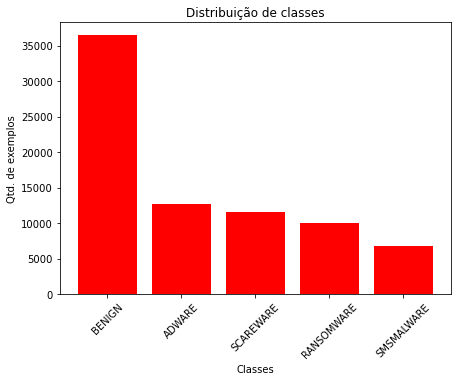

In [141]:
# Exibe novamente a distribuição dos dados
funcoes_uteis.plot_distribuicao_classes(df, 'Label')

# Treinamento

- O treinamento será feito com os algoritmos KNN,Random Forest e MLP.

In [142]:
# Lista com os melhores classificados que serão utilizados na validação
dic_melhores_modelos = {'split_perc_knn':[],
                        'split_perc_rf':[],
                        'split_perc_mlp':[],
                        'melhor_val_cruz_knn':[],
                        'melhor_val_cruz_rf':[],
                        'melhor_val_cruz_mlp':[]}

## Divisão do *dataset*

- O *dataset* será dividido em duas porções uma de validação com 20\% do total de dados, e outra para etapa de treinamento com os outros 80\%.
- Na sequência os 80\% para treinamento serão divididos em mais duas partes dos quais serão 80\% para treinamento dos modelos e 20\% para teste.
- A separação é feita misturando os dados (shuffle=True) e estratificada pela classe *(stratify=df['Label'])* buscando com isso manter a distribuição dos dados.

In [143]:
# Separação inicial 80/20
df_treinamento, df_validacao = train_test_split(df, test_size=0.2, shuffle=True, stratify=df['Label'])

### Distribuição das amostras de treinamento

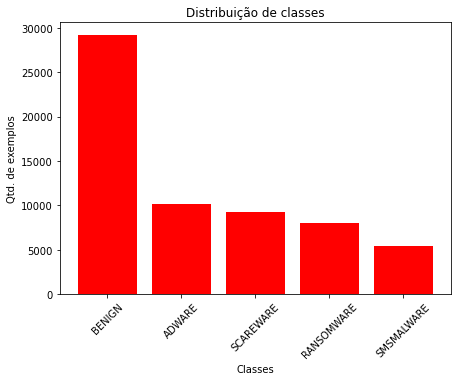

In [13]:
funcoes_uteis.plot_distribuicao_classes(df_treinamento, 'Label')

### Distribuição das amostras de validação

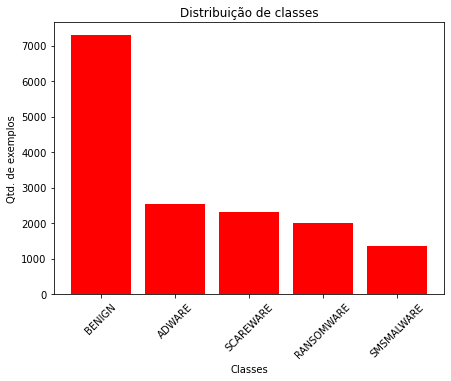

In [14]:
funcoes_uteis.plot_distribuicao_classes(df_validacao, 'Label')

In [144]:
# Separação para treinamento 80/20 sobre o df_treinamento
df_train, df_teste = train_test_split(df_treinamento, test_size=0.2, shuffle=True, stratify=df_treinamento['Label'])

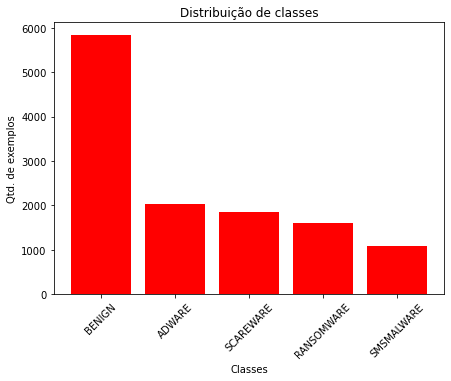

In [16]:
funcoes_uteis.plot_distribuicao_classes(df_teste, 'Label')

## Normalização

- Muitos atributos do *dataset* selecionado possuem diferença de escala muito grande, como os atributos *'Flow Duration'* e *'Total Fwd Packets'*. Essa diferença de escala, dependendo do classificador utilizado, pode dar uma significância muito maior para o primeiro "Flow Duration", já que ele varia muito mais em escala.

- Para resolver este problema será realizada a normalização dos atributos que não representam valores categórigos. No *dataset* utilizado apenas os atributos *' Source Port'*, *' Destination Port'*, *' Protocol'*, *' Label'* e *'NOME_APP'* representam atributos categóricos, os demais atributos serão portanto normalizados.

- Para normalização será utilizado o [min-max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) do scikit learn. O *Min-max Scaling* reescala todas as características em um intervalo entre zero e um, utilizando a equação:

$$z_i = \dfrac{x_i - min(x)}{max(x)-min(x)}$$

em que:
- $x_i$ é o valor da característica $x$ de um examplar $i$;
- $min(x)$ é o menor valor da característica $x$ no conjunto de treino;
- $max(x)$ é o maior valor da característica $x$ no conjunto de treino.

In [145]:
# Obtém colunas
colunas = list(df_train.columns)
# Colunas que devem ser removidas
colunas_remov = [' Source Port', ' Destination Port', ' Protocol', 'NOME_APP', 'Label']
# Remove colunas que NÃO serão normalizadas
for coluna in colunas_remov:
    colunas.remove(coluna)

# Inicializa o MinMax
scaler = MinMaxScaler(feature_range=(0,1))
# Treina MinMax somente as colunas selecionadas
scaler.fit(df_train[colunas])
# Transform as características
train_caract_norm = scaler.transform(df_train[colunas])
teste_caract_norm = scaler.transform(df_teste[colunas])
valid_caract_norm = scaler.transform(df_validacao[colunas])
treinamento_caract_norm = scaler.transform(df_treinamento[colunas])

# Cria os DataFrames normalizados
df_train_norm = pd.DataFrame(train_caract_norm, columns=colunas,index=df_train.index)
df_teste_norm = pd.DataFrame(teste_caract_norm, columns=colunas,index=df_teste.index)
df_validacao_norm = pd.DataFrame(valid_caract_norm, columns=colunas,index=df_validacao.index)
df_treinamento_norm = pd.DataFrame(treinamento_caract_norm, columns=colunas,index=df_treinamento.index)

# Concatena as colunas não normalizadas aos novos DataFrame e reorganiza as colunas
df_train_norm =  pd.concat([df_train_norm, df_train[colunas_remov]], axis=1)
df_train_norm = df_train_norm[df_train.columns]

df_teste_norm =  pd.concat([df_teste_norm, df_teste[colunas_remov]], axis=1)
df_teste_norm = df_teste_norm[df_teste.columns]

df_validacao_norm =  pd.concat([df_validacao_norm, df_validacao[colunas_remov]], axis=1)
df_validacao_norm = df_validacao_norm[df_validacao.columns]

df_treinamento_norm = pd.concat([df_treinamento_norm, df_treinamento[colunas_remov]], axis=1)
df_treinamento_norm = df_treinamento_norm[df_treinamento.columns]

## Treinamento *percentage split*

- Nesta etapa serão realizados treinamentos com a divisão dos dados em duas partes uma de 80\% para treinamento e outra de 20\%, essa divisão foi realizada sobre os 80\% dos dados, como já visto nas etapas anteriores
- Inicialmente serão realizados os treinamentos variando alguns hiperparâmetros dos algoritmos para identificar os que proporcionam os melhores resultados, analisando para isso a acurácia de cada modelo gerado. Na sequência os melhores hiperparâmetros serão utilizados para um novo treinamento em que serão exibidos a matriz de confusão, Curva ROC, acurácia e erro do modelo.

### Preparação dos dados para treinamento, normalizados e não normalizados

In [146]:
# Remove a coluna NOME_APP
df_train_norm = df_train_norm.drop('NOME_APP', axis=1)
df_train = df_train.drop('NOME_APP', axis=1)

df_teste_norm = df_teste_norm.drop('NOME_APP', axis=1)
df_teste = df_teste.drop('NOME_APP', axis=1)

In [147]:
# Dados de treinamento
X_train_norm = df_train_norm.iloc[:,0:-1].values
y_train_norm = df_train_norm.iloc[:,-1].values

X_train = df_train.iloc[:,0:-1].values
y_train = df_train.iloc[:,-1].values

In [148]:
# Dados de teste
X_teste_norm = df_teste_norm.iloc[:,0:-1].values
y_teste_norm = df_teste_norm.iloc[:,-1].values

X_teste = df_teste.iloc[:,0:-1].values
y_teste = df_teste.iloc[:,-1].values

### KNN (*K-nearest neighbors algorithm*)

- Neste algoritmo serão variados o parâmetro número de vizinhos (*n_neighbors*) de 3 até 100 para detectar o melhor parâmetro. As métricas de distância testadas serão a *euclidean* e *manhattan*

In [111]:
numero_de_vizinhos = [3,5,7,9,11,13,15,25,45,70,100]
metricas_de_distancia = ['euclidean', 'manhattan']

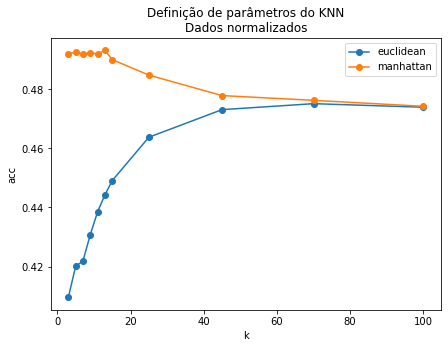

In [112]:
# Dados normalizados
acc = []
ks = []
metricas = []
for metrica in metricas_de_distancia:
    for k in numero_de_vizinhos:
        # Cria modelo
        clf_KNN = KNeighborsClassifier(n_neighbors=k, metric=metrica)
        # Treina modelo
        clf_KNN.fit(X_train_norm, y_train_norm)
        # Faz predição sobre os dados de teste
        y_pred = clf_KNN.predict(X_teste_norm)
        # Calcula a acurácia
        acuracia = accuracy_score(y_teste_norm, y_pred)
        acc.append(acuracia)
        ks.append(k)
        metricas.append(metrica)

# Exibe os resultados
funcoes_uteis.plot_resultados(ks, 'k', 
                                  acc, 'acc', metricas, 
                                  'Definição de parâmetros do KNN\nDados normalizados')

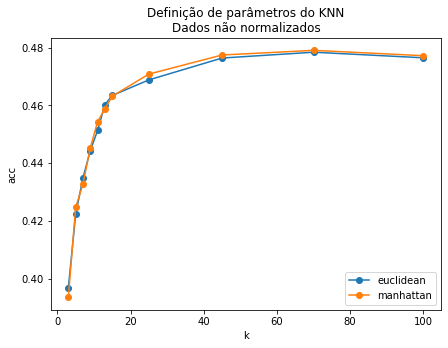

In [113]:
# Dados não normalizados
acc = []
ks = []
metricas = []
for metrica in metricas_de_distancia:
    for k in numero_de_vizinhos:
        # Cria modelo
        clf_KNN = KNeighborsClassifier(n_neighbors=k, metric=metrica)
        # Treina modelo
        clf_KNN.fit(X_train, y_train)
        # Faz predição sobre os dados de teste
        y_pred = clf_KNN.predict(X_teste)
        # Calcula a acurácia
        acuracia = accuracy_score(y_teste, y_pred)
        acc.append(acuracia)
        ks.append(k)
        metricas.append(metrica)

# Exibe os resultados
funcoes_uteis.plot_resultados(ks, 'k', 
                    acc, 'acc', metricas, 
                    'Definição de parâmetros do KNN\nDados não normalizados')

#### Discussão

- No KNN a utilização dos **dados normalizados** chegaram a resultados sensivelmente melhores, pelos experimentos o melhor valor de k foi 13 e a melhor métrica de distância foi a *manhattan*. Portanto o experimento para o KNN será executado com os seguintes hiperparâmetros e dados:
    + Dados: Normalizados
    + Número de vizinhos (k): 13
    + Métrica de distância: *manhattan*

In [87]:
clf_KNN = KNeighborsClassifier(n_neighbors=13, metric='manhattan')
# Treina modelo
clf_KNN.fit(X_train_norm, y_train_norm)
# Faz predição sobre os dados de teste
y_pred = clf_KNN.predict(X_teste_norm)
# Imprime resultados
print(classification_report(y_pred, y_teste_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.19      0.46      0.27       857
      BENIGN       0.94      0.50      0.66     10821
  RANSOMWARE       0.07      0.35      0.12       339
   SCAREWARE       0.04      0.25      0.08       322
  SMSMALWARE       0.02      0.37      0.04        68

    accuracy                           0.49     12407
   macro avg       0.25      0.39      0.23     12407
weighted avg       0.83      0.49      0.60     12407



In [88]:
# Calcula erro (1-accuracy)
accuracy = accuracy_score(y_teste, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.490
Erro: 0.510


In [89]:
# Guarda o modelo gerado
dic_melhores_modelos['split_perc_knn'] = []
dic_melhores_modelos['split_perc_knn'] = []

dic_melhores_modelos['split_perc_knn'].append(clf_KNN)
dic_melhores_modelos['split_perc_knn'].append(accuracy)

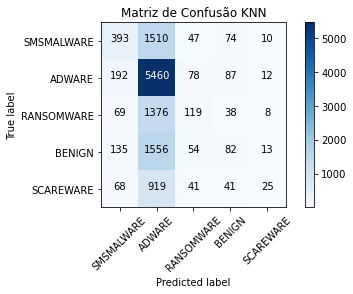

In [90]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_teste, y_pred, 
                                    set(y_teste), 
                                    'Matriz de Confusão KNN')

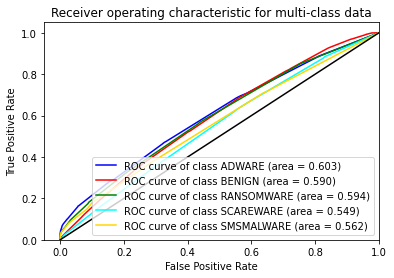

In [119]:
# Exibe curva ROC
funcoes_uteis.plot_roc_curve(clf_KNN, X_train, y_train, X_teste, y_teste)

### *Random Forest*

- Neste algoritmo foi feita a variação do hiperparâmetro número estimadores (*n_estimators*) de 5 até 100 para detectar o melhor.

In [121]:
numero_de_estimadores = [5,10,20,30,40,50,75,100]

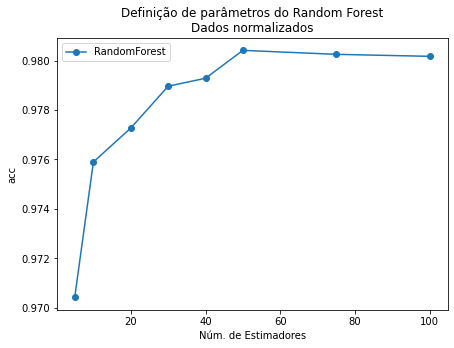

In [122]:
# Dados normalizados
acc = []
num_estimadores = []
divisao = []
for n_estimators in numero_de_estimadores:
    # Cria modelo
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    # Treina modelo
    clf_rf.fit(X_train_norm, y_train_norm)
    # Faz predição sobre os dados de teste
    y_pred = clf_rf.predict(X_teste_norm)
    # Calcula a acurácia
    acuracia = accuracy_score(y_teste_norm, y_pred)
    acc.append(acuracia)
    num_estimadores.append(n_estimators)
    divisao.append('RandomForest')

# Exibe os resultados
funcoes_uteis.plot_resultados(num_estimadores, 'Núm. de Estimadores', 
                            acc, 'acc', divisao, 
                            'Definição de parâmetros do Random Forest\nDados normalizados')

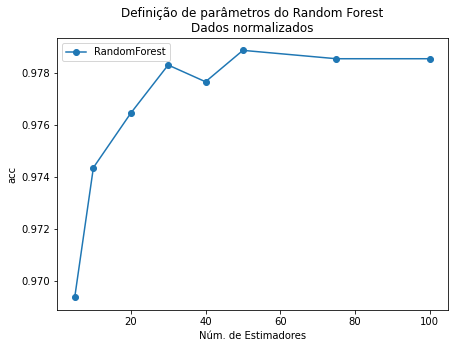

In [123]:
# Dados não normalizados
acc = []
num_estimadores = []
divisao = []
for n_estimators in numero_de_estimadores:
    # Cria modelo
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    # Treina modelo
    clf_rf.fit(X_train, y_train)
    # Faz predição sobre os dados de teste
    y_pred = clf_rf.predict(X_teste)
    # Calcula a acurácia
    acuracia = accuracy_score(y_teste, y_pred)
    acc.append(acuracia)
    num_estimadores.append(n_estimators)
    divisao.append('RandomForest')

# Exibe os resultados
funcoes_uteis.plot_resultados(num_estimadores, 'Núm. de Estimadores', 
                            acc, 'acc', divisao, 
                            'Definição de parâmetros do Random Forest\nDados normalizados')

#### Discussão

- Para o *RandomForest* a utilização dos **dados normalizados** chegaram a resultados sensivelmente melhores, pelos experimentos a melhor quantidade de estimadores foi 50. Portanto o experimento para o *RandomForest* será executado com os seguintes hiperparâmetros e dados:
    + Dados: Normalizados
    + Número de estimadores: 50

In [91]:
# Cria modelo
clf_rf = RandomForestClassifier(n_estimators = 50, random_state=0)
# Treina modelo
clf_rf.fit(X_train_norm, y_train_norm)
# Faz predição sobre os dados de teste
y_pred = clf_rf.predict(X_teste_norm)
# Imprime resultados
print(classification_report(y_pred, y_teste_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.97      0.99      0.98      2000
      BENIGN       1.00      0.97      0.98      5970
  RANSOMWARE       0.98      1.00      0.99      1581
   SCAREWARE       0.96      0.99      0.97      1775
  SMSMALWARE       0.96      0.97      0.96      1081

    accuracy                           0.98     12407
   macro avg       0.97      0.98      0.98     12407
weighted avg       0.98      0.98      0.98     12407



In [92]:
# Calcula erro (1-accuracy)
accuracy = accuracy_score(y_teste_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.981
Erro: 0.019


In [93]:
# Guarda o modelo gerado
dic_melhores_modelos['split_perc_rf'] = []
dic_melhores_modelos['split_perc_rf'] = []

dic_melhores_modelos['split_perc_rf'].append(clf_rf)
dic_melhores_modelos['split_perc_rf'].append(accuracy)

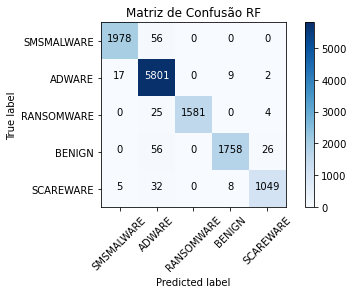

In [94]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_teste_norm, y_pred, 
                                    set(y_teste_norm), 
                                    'Matriz de Confusão RF')

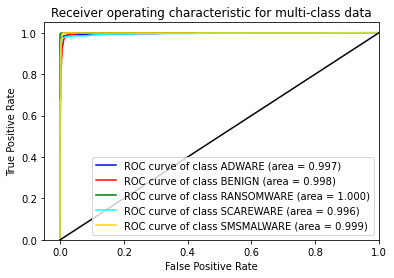

In [127]:
# Exibe curva ROC
funcoes_uteis.plot_roc_curve(clf_rf, X_train_norm, y_train_norm, 
                             X_teste_norm, y_teste_norm)

### MLP (*Multi-layer Perceptron*)

- Neste algoritmo serão variados o hiperparametro de número de camadas ocultas x número de neurônios, (*hidden_layer_sizes*) variando as camadas 1 até 2 e número de neurônios de 50 até 100 para detectar o melhor parâmetro.

In [129]:
tamanhos_camada_oculta = [(50,),(100,),(150,),(50,50),(100,100),
                          (150,150)]

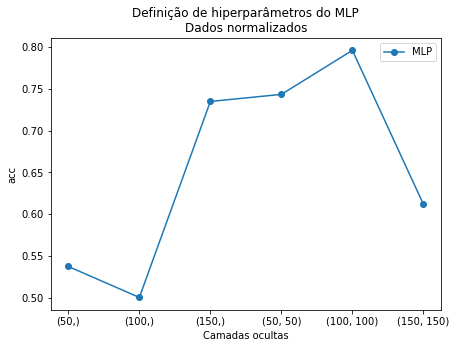

In [144]:
# Dados normalizados
acc = []
num_camadas = []
divisao = []
for camadas_ocultas in tamanhos_camada_oculta:
    # Cria modelo
    clf_mlp =  MLPClassifier(hidden_layer_sizes=camadas_ocultas, random_state=1)
    # Treina modelo
    clf_mlp.fit(X_train_norm, y_train_norm)
    # Faz predição sobre os dados de teste
    y_pred = clf_mlp.predict(X_teste_norm)
    # Calcula a acurácia
    acuracia = accuracy_score(y_teste_norm, y_pred)
    acc.append(acuracia)
    num_camadas.append(str(camadas_ocultas))
    divisao.append('MLP')

# Exibe os resultados
funcoes_uteis.plot_resultados(num_camadas, 'Camadas ocultas', 
                            acc, 'acc', divisao, 
                            'Definição de hiperparâmetros do MLP\nDados normalizados', figsize=(7,5))

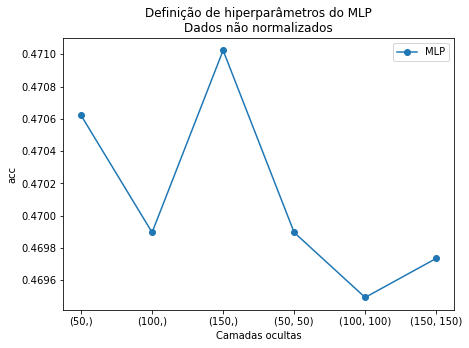

In [133]:
# Dados não normalizados
acc = []
num_camadas = []
divisao = []
for camadas_ocultas in tamanhos_camada_oculta:
    # Cria modelo
    clf_mlp =  MLPClassifier(hidden_layer_sizes=camadas_ocultas, random_state=1)
    # Treina modelo
    clf_mlp.fit(X_train, y_train)
    # Faz predição sobre os dados de teste
    y_pred = clf_mlp.predict(X_teste)
    # Calcula a acurácia
    acuracia = accuracy_score(y_teste, y_pred)
    acc.append(acuracia)
    num_camadas.append(str(camadas_ocultas))
    divisao.append('MLP')

# Exibe os resultados
funcoes_uteis.plot_resultados(num_camadas, 'Camadas ocultas', 
                            acc, 'acc', divisao, 
                            'Definição de hiperparâmetros do MLP\nDados não normalizados', figsize=(7,5))

#### Discussão

- Para o MLP a utilização dos **dados normalizados** chegaram a resultados melhores, pelos experimentos o melhor configuração das camadas ocultas é (100,100). Portanto o experimento para o *MLP* será executado com os seguintes hiperparâmetros e dados:
    + Dados: Normalizados
    + Configuração de camadas ocultas: (100,100)

In [149]:
# Cria modelo
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,100), random_state=1)
# Treina modelo
clf_mlp.fit(X_train_norm, y_train_norm)
# Faz predição sobre os dados de teste
y_pred = clf_mlp.predict(X_teste_norm)
# Imprime resultados
print(classification_report(y_pred, y_teste, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.83      0.78      0.81      2144
      BENIGN       0.90      0.80      0.85      6509
  RANSOMWARE       0.83      0.92      0.87      1455
   SCAREWARE       0.72      0.84      0.78      1586
  SMSMALWARE       0.62      0.94      0.74       713

    accuracy                           0.83     12407
   macro avg       0.78      0.86      0.81     12407
weighted avg       0.84      0.83      0.83     12407



In [150]:
# Calcula erro (1-accuracy)
accuracy = accuracy_score(y_teste_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.827
Erro: 0.173


In [151]:
# Guarda o modelo gerado
dic_melhores_modelos['split_perc_mlp'] = []
dic_melhores_modelos['split_perc_mlp'] = []

dic_melhores_modelos['split_perc_mlp'].append(clf_mlp)
dic_melhores_modelos['split_perc_mlp'].append(accuracy)

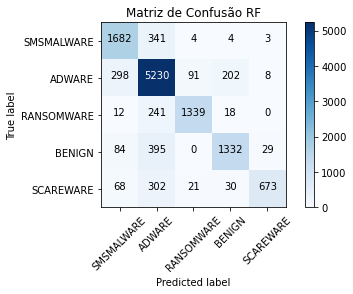

In [152]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_teste_norm, y_pred, 
                                    set(y_teste_norm), 
                                    'Matriz de Confusão RF')

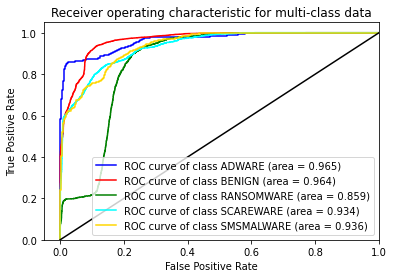

In [153]:
# Exibe curva ROC
funcoes_uteis.plot_roc_curve(clf_mlp, X_train_norm, y_train_norm, 
                             X_teste_norm, y_teste_norm)

### Comparação de Resultados e discussão

- É possível observar pelos experimentos anteriores e pelo gráfico abaixo que o KNN não consegue separar bem as classes. Isto pode ser observando tanto na matriz de confusão quanto pela curva ROC, uma vez que as linhas se aproximam muito do meio do gráfico. O *Random Forest* obteve os melhores resultados para predição de todas as classes, com índice muito baixo de falsos positivos, conforme pode ser visto pela curva ROC do algoritmo. O MLP consegue prever razoavelmente bem algumas classes, entretanto tem dificuldades para prever SMSMALWARE e SCAREWARE.
- Entre todos os modelos testados até este ponto, o *Random Forest* é o melhor modelo.

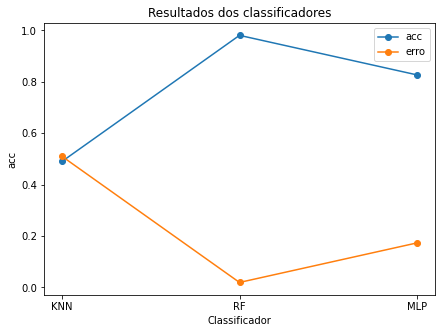

In [162]:
classsificador_split_test = ['KNN', 'RF', 'MLP','KNN', 'RF', 'MLP',]
acuracias_split_test = [0.490,0.981,0.827,1-0.490,1-0.981,1-0.827]
divisao_split_test = ['acc','acc','acc','erro','erro','erro']

# Exibe os resultados
funcoes_uteis.plot_resultados(classsificador_split_test, 'Classificador', 
                            acuracias_split_test, 'acc', divisao_split_test, 
                            'Resultados dos classificadores', figsize=(7,5))

## Treinamento e teste com validação cruzada

- Nesta etapa serão realizados treinamentos e teste com validação cruzada em 5 partes (*folds*). Para o treinamento e teste serão utilizados os 80\% dos dados separados anteriormente.

- Os treinamentos serão realizados considerando os melhores hiperparâmentros encontrados anteriormente para os algoritmos. Para cada etapa do treinamento será exibido a matriz de confusão, Curva ROC, acurácia e erro do modelo.

### Preparação dos dados para treinamento, normalizados e não normalizados

In [19]:
# Remove a coluna NOME_APP
df_treinamento_norm = df_treinamento_norm.drop('NOME_APP', axis=1)
df_treinamento = df_treinamento.drop('NOME_APP', axis=1)

In [20]:
# Dados totais de treinamento
X_treinamento_norm = df_treinamento_norm.iloc[:,0:-1].values
y_treinamento_norm = df_treinamento_norm.iloc[:,-1].values

X_treinamento = df_treinamento.iloc[:,0:-1].values
y_treinamento = df_treinamento.iloc[:,-1].values

### KNN (*K-nearest neighbors algorithm*)

- Neste algoritmo utilizados serão os mesmos hiperparametros da etapa *percentage split*. Portanto o experimento para o KNN será executado com os seguintes hiperparâmetros e dados:
    + Dados: Normalizados
    + Número de vizinhos (k): 13
    + Métrica de distância: *manhattan*

Acurácia: 0.494
Erro: 0.506


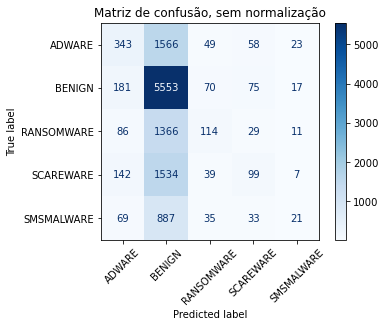

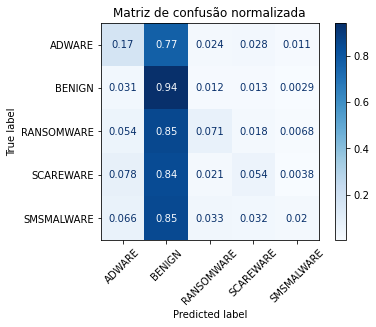

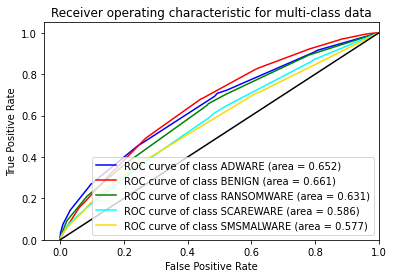

Acurácia: 0.491
Erro: 0.509


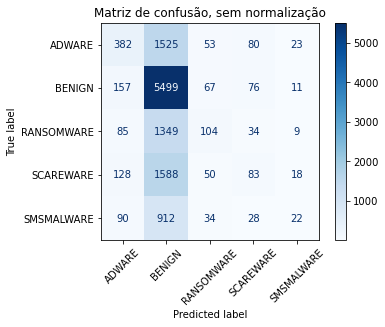

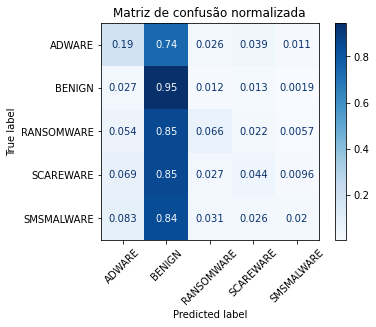

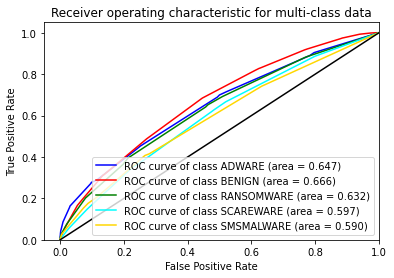

Acurácia: 0.489
Erro: 0.511


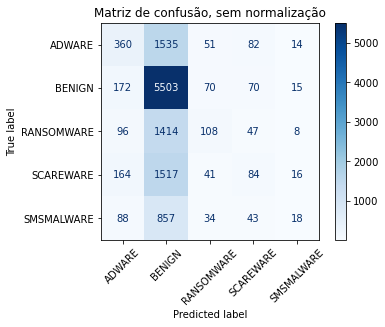

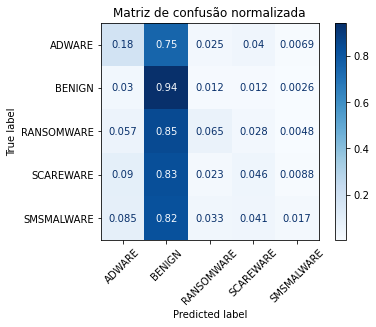

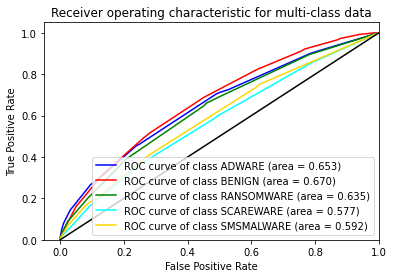

Acurácia: 0.487
Erro: 0.513


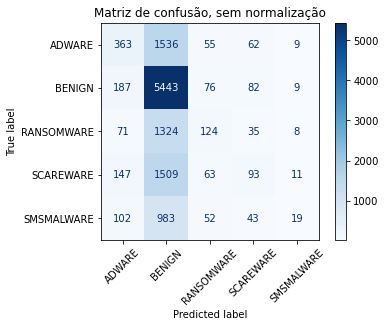

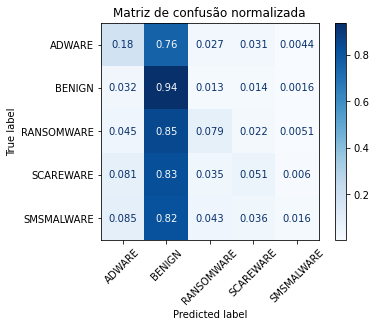

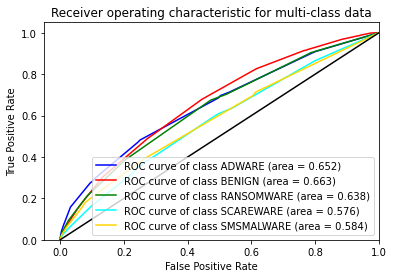

Acurácia: 0.488
Erro: 0.512


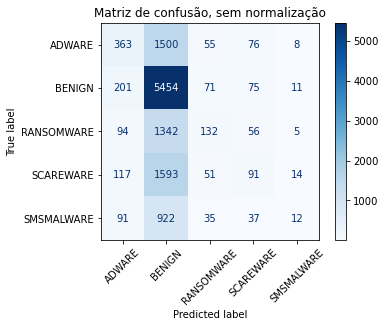

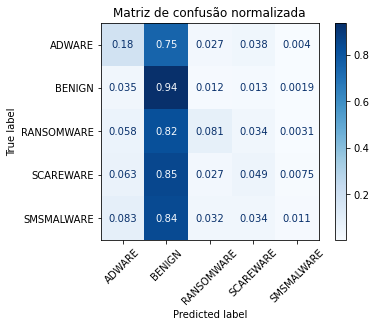

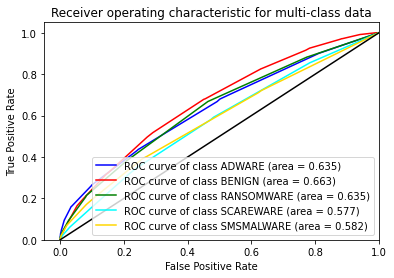

Média: 0.48985209721735484


In [21]:
clf_kNN = KNeighborsClassifier(n_neighbors=13, metric='manhattan')

scores, models, folds = funcoes_uteis.k_fold_train(clf_kNN, df_treinamento_norm, clf_name='KNN')

In [23]:
media_acc = sum(scores)/len(scores)
media_erro = 1 - media_acc
print("Acurácia média:", media_acc)
print("Erro médio:", media_erro)

Acurácia média: 0.48985209721735484
Erro médio: 0.5101479027826452


In [33]:
scores_array = np.array(scores)
models_array = np.array(models)
folds_array = np.array(folds)
index = np.where(scores_array == max(scores_array))
melhor_model_KNN_k_fold = models_array[index[0]][0]
KNN_k_fold = folds_array[index[0]]

In [37]:
# Guarda o modelo gerado
dic_melhores_modelos['melhor_val_cruz_knn'] = []
dic_melhores_modelos['melhor_val_cruz_knn'] = []
dic_melhores_modelos['melhor_val_cruz_knn'] = []

dic_melhores_modelos['melhor_val_cruz_knn'].append(melhor_model_KNN_k_fold)
dic_melhores_modelos['melhor_val_cruz_knn'].append(media_acc)
dic_melhores_modelos['melhor_val_cruz_knn'].append(KNN_k_fold)

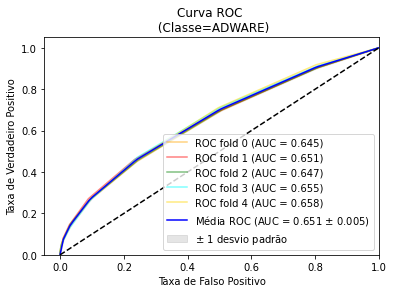

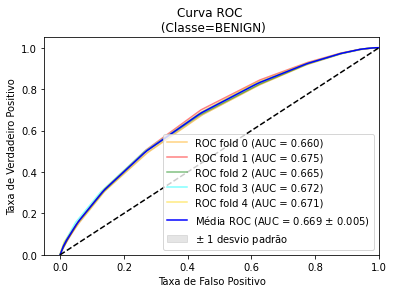

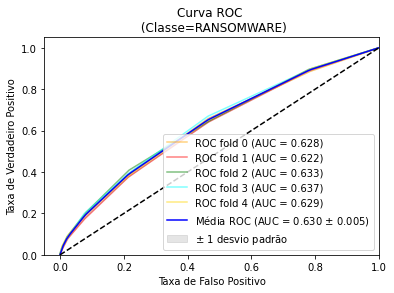

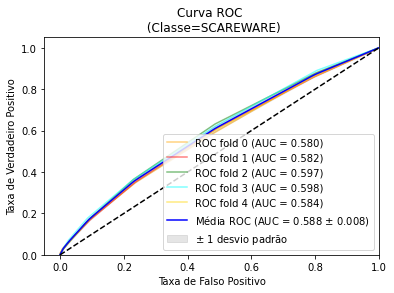

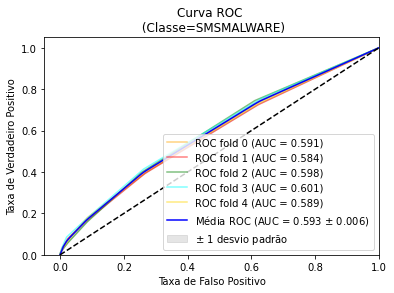

In [28]:
# Curva ROC por classe
funcoes_uteis.plot_roc_k_fold(clf_kNN, X_treinamento_norm, y_treinamento_norm, 5)

### *Random Forest*

- Neste algoritmo foi utilizados os mesmos hiperparametros da etapa *percentage split*. Portanto o experimento para o *Random Forest* será executado com o seguinte hiperparâmetros e dados:
    + Dados: Normalizados
    + Número de estimadores: 50

Acurácia: 0.979
Erro: 0.021


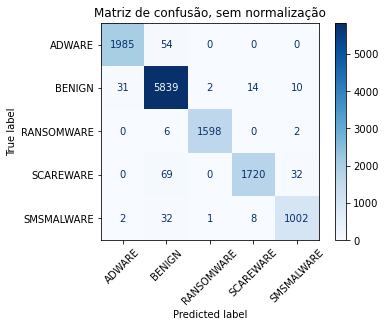

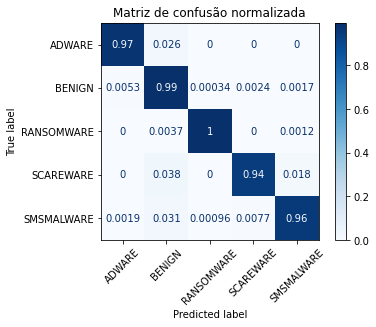

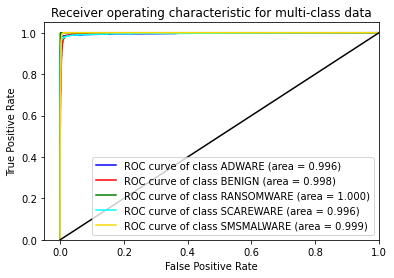

Acurácia: 0.979
Erro: 0.021


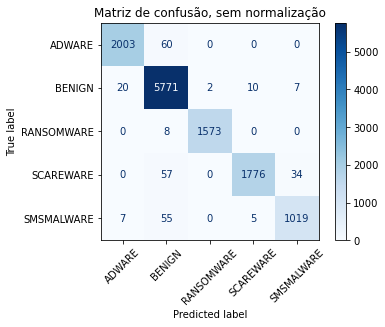

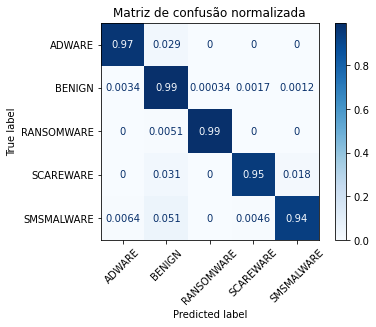

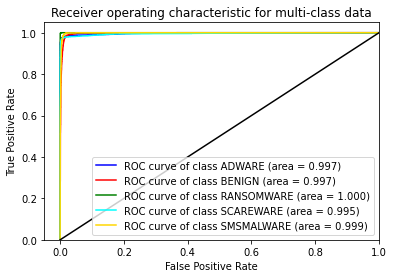

Acurácia: 0.979
Erro: 0.021


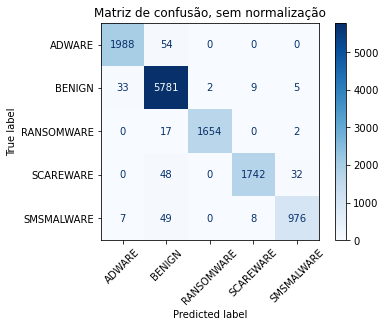

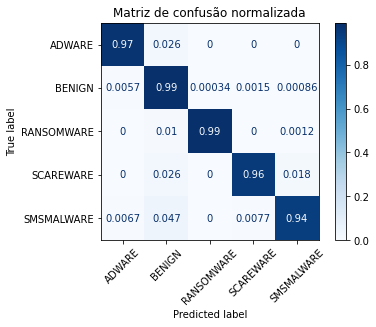

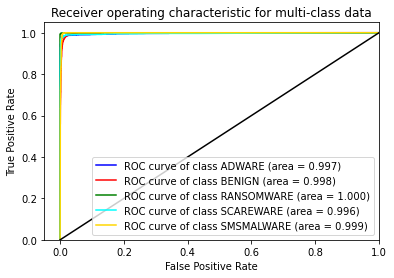

Acurácia: 0.979
Erro: 0.021


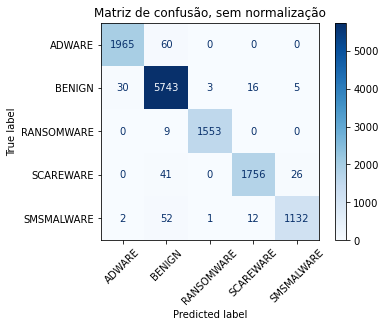

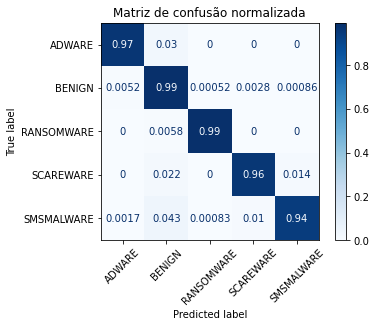

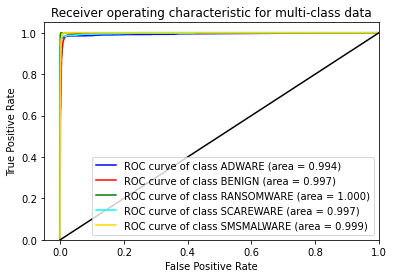

Acurácia: 0.976
Erro: 0.024


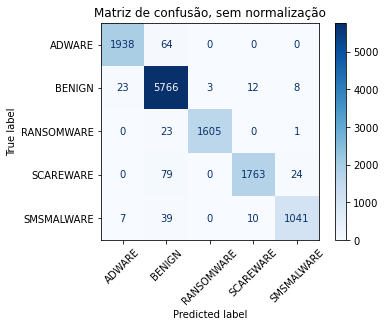

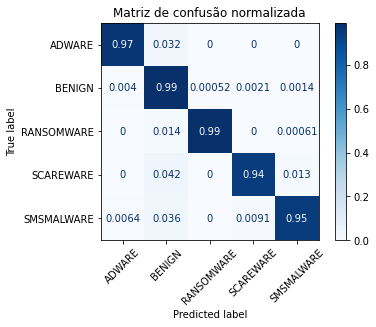

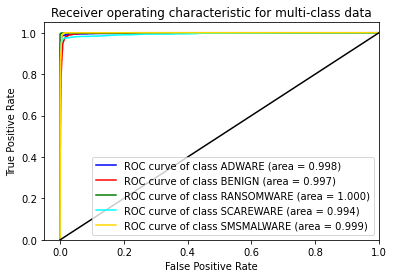

Média: 0.9783340963425958


In [73]:
clf_rf = RandomForestClassifier(n_estimators = 50, random_state=0)

scores, models, folds = funcoes_uteis.k_fold_train(clf_rf, df_treinamento_norm, clf_name='RF')

In [74]:
media_acc = sum(scores)/len(scores)
media_erro = 1 - media_acc
print("Acurácia média:", media_acc)
print("Erro médio:", media_erro)

Acurácia média: 0.9783340963425958
Erro médio: 0.021665903657404173


In [75]:
scores_array = np.array(scores)
models_array = np.array(models)
folds_array = np.array(folds)
index = np.where(scores_array == max(scores_array))
melhor_model_RF_k_fold = models_array[index]
RF_k_fold = folds_array[index[0]]

In [76]:
# Guarda o modelo gerado
dic_melhores_modelos['melhor_val_cruz_rf'].append(melhor_model_RF_k_fold)
dic_melhores_modelos['melhor_val_cruz_rf'].append(media_acc)
dic_melhores_modelos['melhor_val_cruz_rf'].append(RF_k_fold)

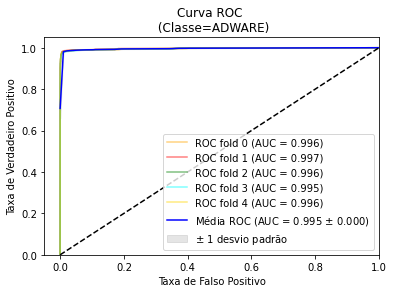

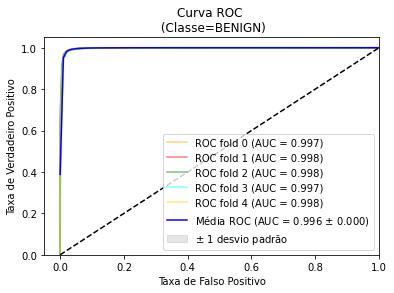

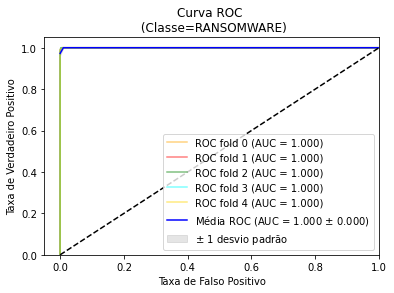

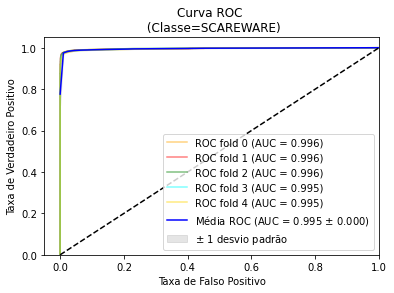

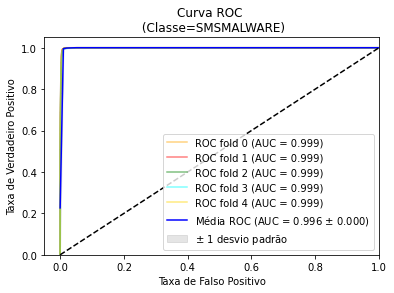

In [36]:
# Curva ROC por classe
funcoes_uteis.plot_roc_k_fold(clf_rf, X_treinamento_norm, y_treinamento_norm, 5)

### MLP (*Multi-layer Perceptron*)

- Neste algoritmo foram utilizados os mesmos hiperparametros da etapa *percentage split*. Portanto o experimento para o MLP será executado com os seguintes hiperparâmetros e dados:
    + Dados: Normalizados
    + Configuração de camadas ocultas: (100,100)

Acurácia: 0.839
Erro: 0.161


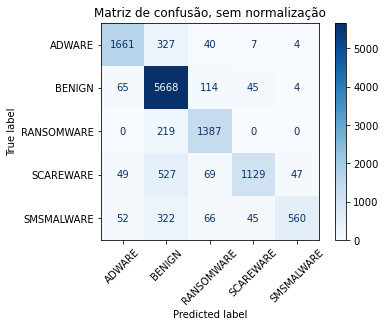

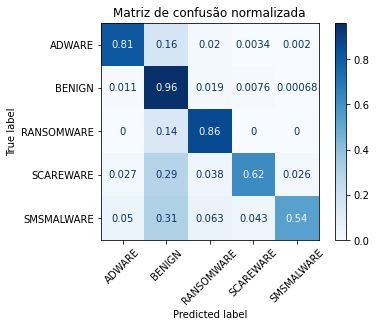

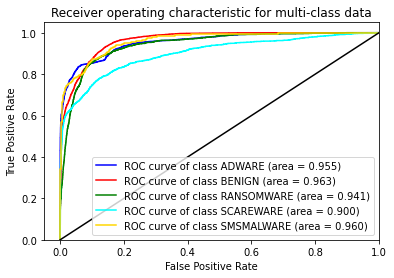

Acurácia: 0.787
Erro: 0.213


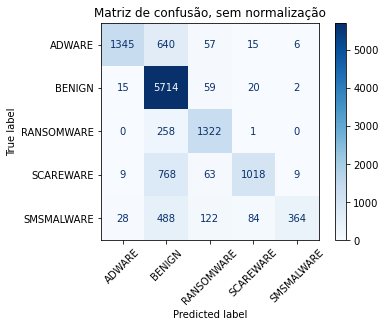

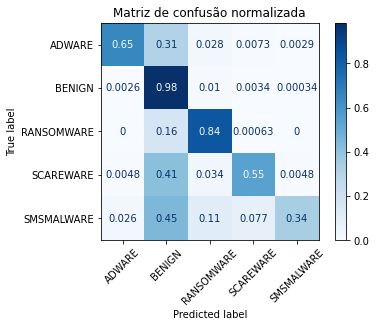

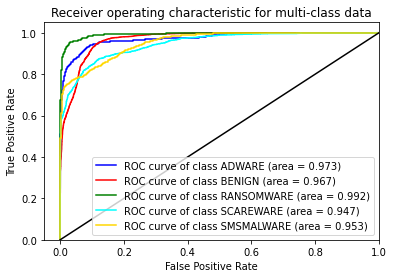

Acurácia: 0.708
Erro: 0.292


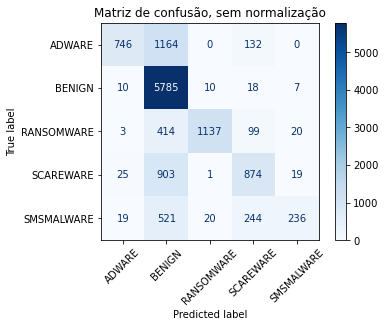

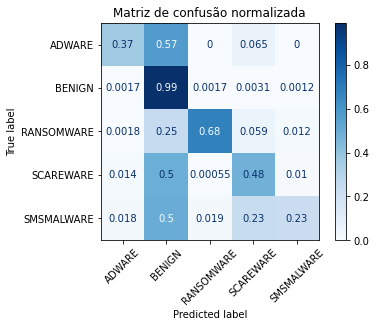

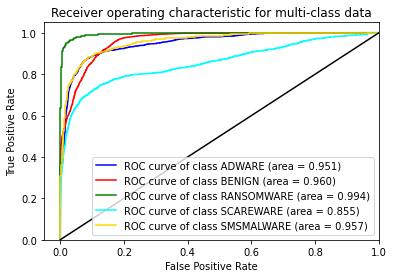

Acurácia: 0.823
Erro: 0.177


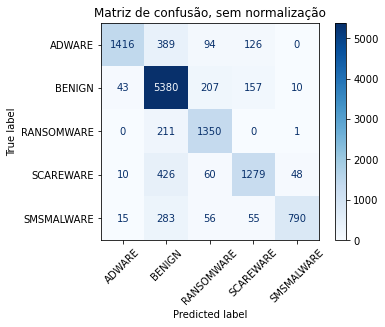

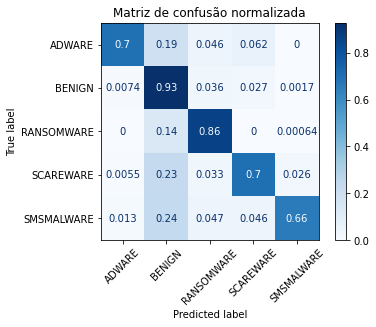

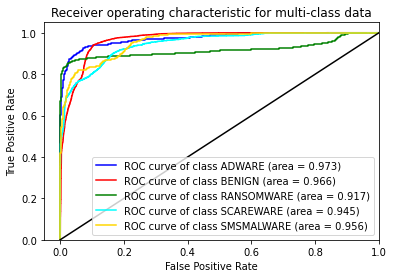

Acurácia: 0.773
Erro: 0.227


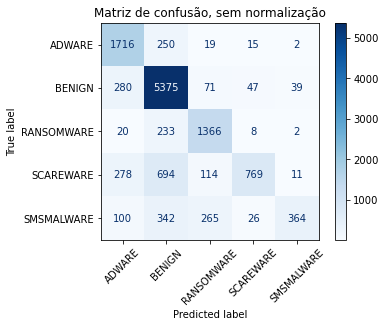

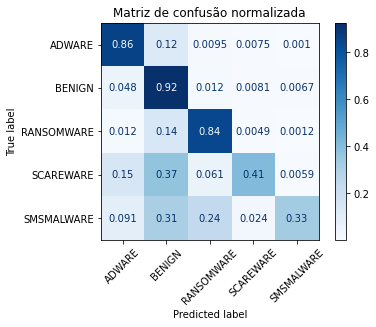

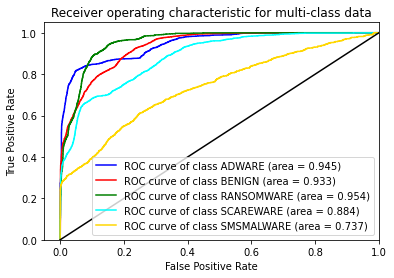

Média: 0.7858885533161174


In [60]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,100), random_state=1)

scores, models, folds = funcoes_uteis.k_fold_train(clf_mlp, df_treinamento_norm, clf_name='MLP')

In [61]:
media_acc = sum(scores)/len(scores)
media_erro = 1 - media_acc
print("Acurácia média:", media_acc)
print("Erro médio:", media_erro)

Acurácia média: 0.7858885533161174
Erro médio: 0.2141114466838826


In [76]:
scores_array = np.array(scores)
models_array = np.array(models)
folds_array = np.array(folds)
index = np.where(scores_array == max(scores_array))
melhor_model_mlp_k_fold = models_array[index]
MLP_k_fold = folds_array[index[0]]

In [63]:
# Guarda o modelo gerado
dic_melhores_modelos['melhor_val_cruz_mlp'].append(melhor_model_mlp_k_fold)
dic_melhores_modelos['melhor_val_cruz_mlp'].append(media_acc)
dic_melhores_modelos['melhor_val_cruz_mlp'].append(MLP_k_fold)

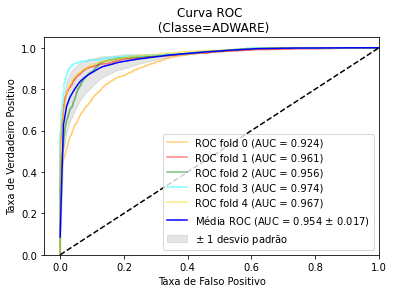

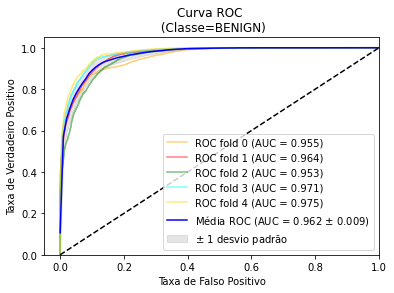

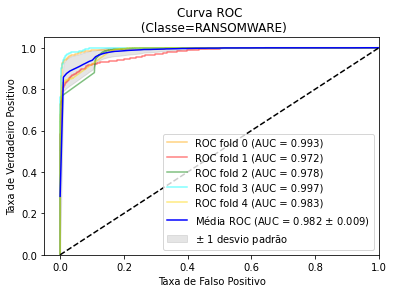

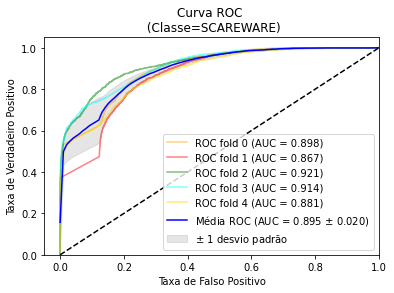

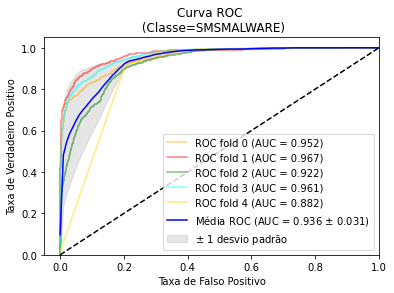

In [43]:
# Curva ROC por classe
funcoes_uteis.plot_roc_k_fold(clf_mlp, X_treinamento_norm, y_treinamento_norm, 5)

### Comparação de Resultados e discussão

- É possível observar pelos experimentos com validação cruzada que os resultados são similares aos com *percentage split*, o gráfico abaixo demonstra claramente a similaridade. Esta similaridade permite-se dizer que os modelos gerados apenas com *percentage split* tendem a ser confiáveis. Novamente o MLP apresentou dificuldades em prever SMSMALWARE e SCAREWARE. Esta dificuldade fica fácil de se observar nestes experimentos, pois foi possível traçar a curva ROC por classe para cada *fold* e para estas duas classes a curva é mais próxima ao centro do gráfico.
- Entre todos os modelos gerados, o *Random Forest* conseguiu atingir os melhores resultados. A dificuldade que o MLP apresenta sobre as classes SMSMALWARE e SCAREWARE é superada pelo *Random Forest*, atingindo acertos de mais de 94/%, conforme pode ser visto pela matriz de confusão.

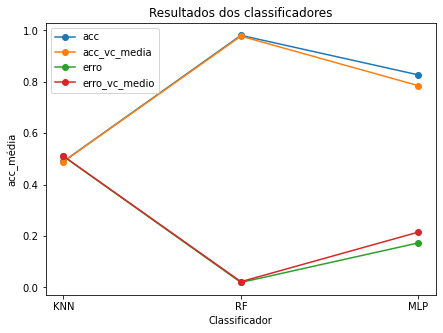

In [164]:
classsificador_vc = classsificador_split_test + ['KNN', 'RF', 'MLP','KNN', 'RF', 'MLP',]
acuracias_medias_vc = acuracias_split_test + [0.489, 0.978, 0.785, 1-0.489, 1-0.978, 1-0.785]
divisao_vc = divisao_split_test + ['acc_vc_media','acc_vc_media','acc_vc_media',
              'erro_vc_medio','erro_vc_medio','erro_vc_medio']

# Exibe os resultados
funcoes_uteis.plot_resultados(classsificador_vc, 'Classificador', 
                            acuracias_medias_vc, 'acc_média', divisao_vc, 
                            'Resultados dos classificadores', figsize=(7,5))

# Validação dos modelos

- Nesta etapa foram calculadas as taxas de acerto, erro e exibidos a matriz de confusão e cuva ROC dos melhores modelos gerados pelas atapas anteriores, utilizando-se para isso os dados de validação.
- Nas estapas anteriores os dados normalizados foram escolhidos por alcançarem os melhores resultados, portanto, nesta etapa, também serão utilizados os dados normalizados.

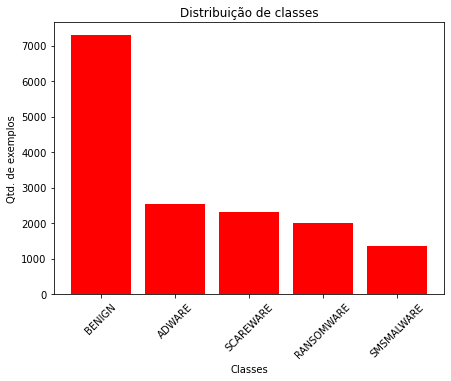

In [55]:
# Distribuição das classes
funcoes_uteis.plot_distribuicao_classes(df_validacao_norm, 'Label')

## Preparação dos dados para validação, normalizados e não normalizados

In [156]:
# Remove a coluna NOME_APP
df_validacao_norm = df_validacao_norm.drop('NOME_APP', axis=1)
df_validacao = df_validacao.drop('NOME_APP', axis=1)

In [157]:
# Dados de validação
X_validacao_norm = df_validacao_norm.iloc[:,0:-1].values
y_validacao_norm = df_validacao_norm.iloc[:,-1].values

X_validacao = df_validacao.iloc[:,0:-1].values
y_validacao = df_validacao.iloc[:,-1].values

##  Melhores modelos gerados com *Percentage split*

### KNN (*K-nearest neighbors algorithm*) 

In [112]:
# Obtém o modelo gerado
modelo_knn_ps = dic_melhores_modelos['split_perc_knn'][0]
y_pred = modelo_knn_ps.predict(X_validacao_norm)
print(classification_report(y_pred, y_validacao_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.18      0.44      0.26      1047
      BENIGN       0.94      0.51      0.66     13588
  RANSOMWARE       0.07      0.36      0.12       405
   SCAREWARE       0.05      0.31      0.09       379
  SMSMALWARE       0.02      0.28      0.03        90

    accuracy                           0.49     15509
   macro avg       0.25      0.38      0.23     15509
weighted avg       0.84      0.49      0.60     15509



In [113]:
 # Calcula erro (1-accuracy)
accuracy = accuracy_score(y_validacao_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.492
Erro: 0.508


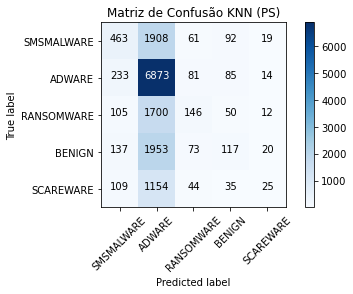

In [114]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_validacao_norm, y_pred, 
                                    set(y_validacao_norm), 
                                    'Matriz de Confusão KNN (PS)')

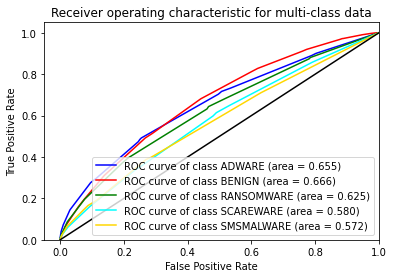

In [115]:
# Exibe curva ROC
funcoes_uteis.plot_roc_curve(modelo_knn_ps, X_train_norm, y_train_norm, 
                             X_validacao_norm, y_validacao_norm)

### *Random Forest*

In [116]:
# Obtém o modelo gerado
modelo_rf_ps = dic_melhores_modelos['split_perc_rf'][0]
y_pred = modelo_rf_ps.predict(X_validacao_norm)
print(classification_report(y_pred, y_validacao_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.97      0.99      0.98      2510
      BENIGN       0.99      0.97      0.98      7481
  RANSOMWARE       0.99      1.00      0.99      1986
   SCAREWARE       0.95      0.99      0.97      2199
  SMSMALWARE       0.94      0.96      0.95      1333

    accuracy                           0.98     15509
   macro avg       0.97      0.98      0.98     15509
weighted avg       0.98      0.98      0.98     15509



In [117]:
# Calcula erro (1-accuracy)
accuracy = accuracy_score(y_validacao_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.978
Erro: 0.022


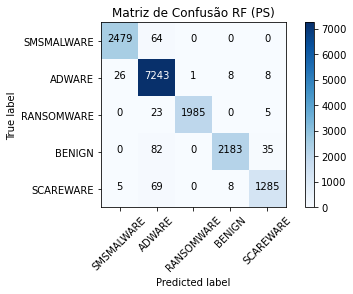

In [118]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_validacao_norm, y_pred, 
                                    set(y_validacao_norm), 
                                    'Matriz de Confusão RF (PS)')

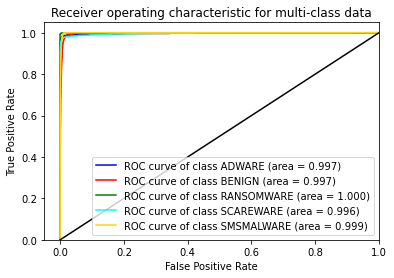

In [119]:
# Exibe curva ROC
funcoes_uteis.plot_roc_curve(modelo_rf_ps, X_train_norm, y_train_norm, 
                             X_validacao_norm, y_validacao_norm)

### MLP (*Multi-layer Perceptron*)

In [158]:
# Obtém o modelo gerado
modelo_mlp_ps = dic_melhores_modelos['split_perc_mlp'][0]
y_pred = modelo_mlp_ps.predict(X_validacao_norm)
print(classification_report(y_pred, y_validacao_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.83      0.78      0.80      2725
      BENIGN       0.90      0.81      0.85      8094
  RANSOMWARE       0.84      0.91      0.87      1864
   SCAREWARE       0.71      0.85      0.77      1924
  SMSMALWARE       0.61      0.92      0.74       902

    accuracy                           0.83     15509
   macro avg       0.78      0.85      0.81     15509
weighted avg       0.84      0.83      0.83     15509



In [159]:
# Calcula erro (1-accuracy)
accuracy = accuracy_score(y_validacao_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.826
Erro: 0.174


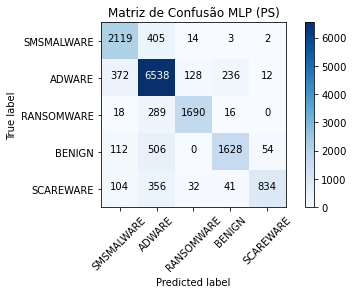

In [160]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_validacao_norm, y_pred, 
                                    set(y_validacao_norm), 
                                    'Matriz de Confusão MLP (PS)')

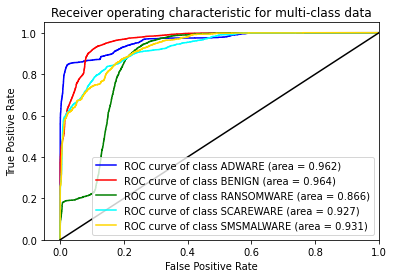

In [161]:
# Exibe curva ROC
funcoes_uteis.plot_roc_curve(modelo_mlp_ps, X_train_norm, y_train_norm, 
                             X_validacao_norm, y_validacao_norm)

##  Melhores modelos gerados com validação cruzada

### KNN (*K-nearest neighbors algorithm*) 

In [45]:
# Obtém o melhor modelo da validação cruzada
melhor_modelo_knn_vc = dic_melhores_modelos['melhor_val_cruz_knn'][0]
y_pred = melhor_modelo_knn_vc.predict(X_validacao_norm)
print(classification_report(y_pred, y_validacao_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.18      0.43      0.26      1095
      BENIGN       0.94      0.51      0.66     13554
  RANSOMWARE       0.06      0.33      0.11       399
   SCAREWARE       0.05      0.31      0.09       388
  SMSMALWARE       0.02      0.30      0.03        73

    accuracy                           0.49     15509
   macro avg       0.25      0.37      0.23     15509
weighted avg       0.84      0.49      0.60     15509



In [46]:
 # Calcula erro (1-accuracy)
accuracy = accuracy_score(y_validacao_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.490
Erro: 0.510


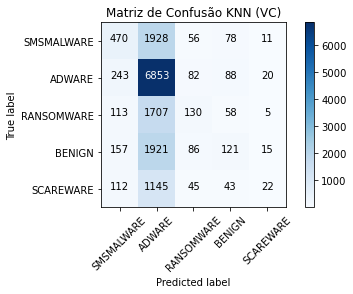

In [47]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_validacao_norm, y_pred, 
                                    set(y_validacao_norm), 
                                    'Matriz de Confusão KNN (VC)')

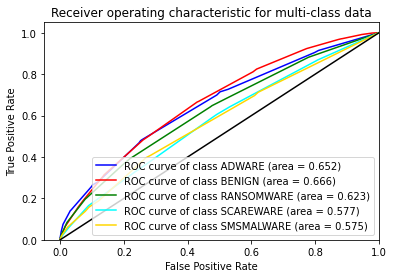

In [57]:
# Exibe curva ROC
X_train_data = dic_melhores_modelos['melhor_val_cruz_knn'][2][0][0]
y_train_data = dic_melhores_modelos['melhor_val_cruz_knn'][2][0][1]
funcoes_uteis.plot_roc_curve(melhor_modelo_knn_vc, X_train_data, y_train_data, 
                             X_validacao_norm, y_validacao_norm)

### *Random Forest*

In [82]:
X_train_data = dic_melhores_modelos['melhor_val_cruz_rf'][2][0][0]
y_train_data = dic_melhores_modelos['melhor_val_cruz_rf'][2][0][1]

clf_rf = RandomForestClassifier(n_estimators = 50, random_state=0)
clf_rf.fit(X_train_data, y_train_data)
melhor_modelo_rf_vc = clf_rf

In [83]:
# Obtém o melhor modelo da validação cruzada
#melhor_modelo_rf_vc = dic_melhores_modelos['melhor_val_cruz_rf'][0][0]
y_pred = melhor_modelo_rf_vc.predict(X_validacao_norm)
print(classification_report(y_pred, y_validacao_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.97      0.99      0.98      2503
      BENIGN       0.99      0.97      0.98      7468
  RANSOMWARE       0.99      1.00      0.99      2005
   SCAREWARE       0.95      0.99      0.97      2207
  SMSMALWARE       0.94      0.97      0.96      1326

    accuracy                           0.98     15509
   macro avg       0.97      0.98      0.98     15509
weighted avg       0.98      0.98      0.98     15509



In [84]:
 # Calcula erro (1-accuracy)
accuracy = accuracy_score(y_validacao_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.978
Erro: 0.022


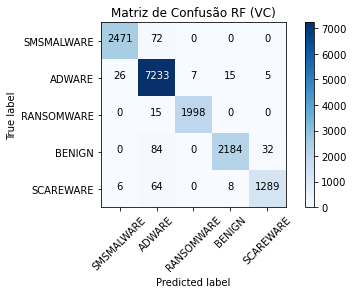

In [85]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_validacao_norm, y_pred, 
                                    set(y_validacao_norm), 
                                    'Matriz de Confusão RF (VC)')

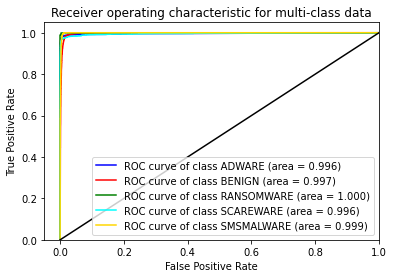

In [99]:
# Exibe curva ROC
X_train_data = dic_melhores_modelos['melhor_val_cruz_rf'][2][0][0]
y_train_data = dic_melhores_modelos['melhor_val_cruz_rf'][2][0][1]
funcoes_uteis.plot_roc_curve(melhor_modelo_rf_vc, X_train_data, y_train_data, 
                             X_validacao_norm, y_validacao_norm)

### MLP (*Multi-layer Perceptron*)

In [68]:
# Obtém o melhor modelo da validação cruzada
melhor_modelo_mlp_vc = dic_melhores_modelos['melhor_val_cruz_mlp'][0][0]
y_pred = melhor_modelo_mlp_vc.predict(X_validacao_norm)
print(classification_report(y_pred, y_validacao_norm, zero_division=True))

              precision    recall  f1-score   support

      ADWARE       0.88      0.73      0.80      3070
      BENIGN       0.93      0.78      0.85      8668
  RANSOMWARE       0.82      0.74      0.78      2241
   SCAREWARE       0.41      0.92      0.57      1032
  SMSMALWARE       0.32      0.88      0.47       498

    accuracy                           0.78     15509
   macro avg       0.67      0.81      0.69     15509
weighted avg       0.85      0.78      0.80     15509



In [69]:
 # Calcula erro (1-accuracy)
accuracy = accuracy_score(y_validacao_norm, y_pred)
erro = 1 - accuracy
print('Acurácia: {:.3f}'.format(accuracy))
print('Erro: {:.3f}'.format(erro))

Acurácia: 0.775
Erro: 0.225


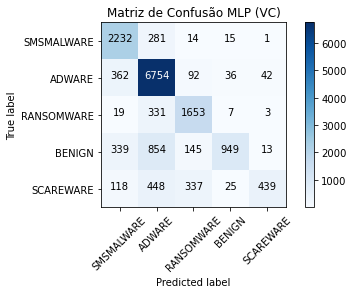

In [70]:
# Exibe a matriz de confusão
funcoes_uteis.plot_confusion_matrix(y_validacao_norm, y_pred, 
                                    set(y_validacao_norm), 
                                    'Matriz de Confusão MLP (VC)')

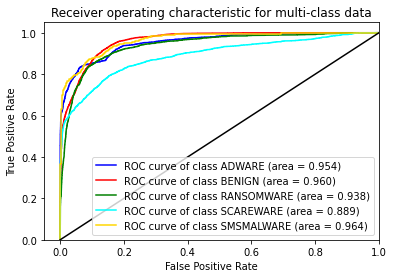

In [71]:
# Exibe curva ROC
X_train_data = dic_melhores_modelos['melhor_val_cruz_mlp'][2][0][0]
y_train_data = dic_melhores_modelos['melhor_val_cruz_mlp'][2][0][1]
funcoes_uteis.plot_roc_curve(melhor_modelo_mlp_vc, X_train_data, y_train_data, 
                             X_validacao_norm, y_validacao_norm)

### Comparação de Resultados e discussão

- Os resultados obtidos com dados de validação permite concluir que os modelos gerados são consistentes com o erro e acurácia anteriormente obtidos, dado a proximidade dos resultados.

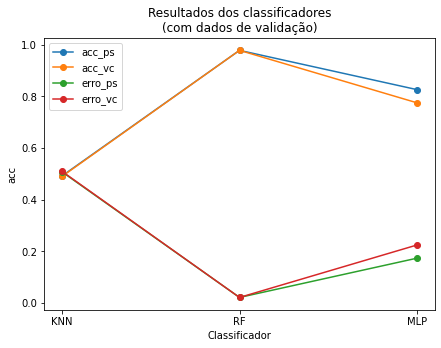

In [171]:
classsificador_valid = ['KNN', 'RF', 'MLP','KNN', 'RF', 'MLP','KNN', 'RF', 'MLP','KNN', 'RF', 'MLP']
acuracias_valid = [0.492, 0.978, 0.826, 1-0.492, 1-0.978, 1-0.826, 0.490, 0.978, 0.775, 1-0.490, 1-0.978, 1-0.775]
divisao_valid = ['acc_ps','acc_ps','acc_ps','erro_ps','erro_ps','erro_ps',
                 'acc_vc','acc_vc','acc_vc','erro_vc','erro_vc','erro_vc']

# Exibe os resultados
funcoes_uteis.plot_resultados(classsificador_valid, 'Classificador', 
                            acuracias_valid, 'acc', divisao_valid, 
                            'Resultados dos classificadores\n(com dados de validação)', figsize=(7,5))

# acc_ps - Acurácia Percentage Split
# acc_vc - Acurácia Validação Cruzada

### Sítese dos resultados

![Resultados](sintese_resultados.png)